In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.model_zoo as model_zoo
from torch.optim import lr_scheduler
import numpy as np
import torchvision
import torch.utils.data as data
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import cv2
import torch.nn.functional as F

%matplotlib inline
plt.ion()

In [2]:
class CubDataset(data.Dataset):
    def __init__(self,
                 root='/datastore/wait_to_review/zhouyang/data/CUB_200_2011/',
                 transform=None,
                 test=False
                 ):
        self.root = root
        self.transform = transform
        self.x = []
        self.y = []
        self.load_data_list(test)

    def load_data_list(self, test):
        images = open(os.path.join(self.root, 'images.txt')).readlines()
        labels = open(os.path.join(self.root, 'image_class_labels.txt')).readlines()
        with open(os.path.join(self.root, 'train_test_split.txt')) as f:
            for line in f.readlines():
                lines = line.strip().split(' ')
                if test and lines[1]=='0':
                    self.x.append(os.path.join(self.root, 'images', images[int(lines[0])-1].strip().split(' ')[1]))
                    self.y.append(int(labels[int(lines[0])-1].strip().split(' ')[1])-1)
                if not test and lines[1]=='1':
                    self.x.append(os.path.join(self.root, 'images', images[int(lines[0])-1].strip().split(' ')[1]))
#                     self.x.append(os.path.join(self.root, 'images_guass_noise', images[int(lines[0])-1].strip().split(' ')[1]))
#                     self.x.append(os.path.join(self.root, 'images_s_p', images[int(lines[0])-1].strip().split(' ')[1]))
#                     self.x.append(os.path.join(self.root, 'images_poisson', images[int(lines[0])-1].strip().split(' ')[1]))
                    self.y.append(int(labels[int(lines[0])-1].strip().split(' ')[1])-1)
#                     self.y.append(int(labels[int(lines[0])-1].strip().split(' ')[1])-1)
#                     self.y.append(int(labels[int(lines[0])-1].strip().split(' ')[1])-1)
#                     self.y.append(int(labels[int(lines[0])-1].strip().split(' ')[1])-1)
    
    def __len__(self):
        return len(self.x)

    def __getitem__(self, item):
        filepath = self.x[item]
        label = self.y[item]

        # image = Image.open(filepath)
        image = cv2.imread(filepath)
        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [3]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(512),
    transforms.RandomHorizontalFlip(0.5),
#     transforms.RandomVerticalFlip(0.5),
    transforms.RandomCrop(448),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
#     transforms.Normalize([0.485, 0.465, 0.406], [0.229, 0.224, 0.225])
    ])
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(448),
    transforms.CenterCrop(448),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# paper fast-MPN-COV
# train_transforms = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize(448),
#     transforms.CenterCrop(448),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
# ])
# val_transforms = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize(448),
#     transforms.CenterCrop(448),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
# ])

batch_size = 16

trainset = CubDataset(transform=train_transform)
testset = CubDataset(transform=test_transform, test=True)


trainloader = data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=8)
testloader = data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=8)

os.environ["CUDA_VISIBLE_DEVICES"]="0"

torch.Size([48, 3, 448, 448])


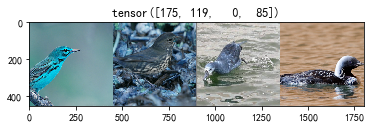

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.465, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    inp = inp[..., ::-1]
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated
    
# Get a batch of training data
inputs, classes = next(iter(trainloader))
print(inputs.shape)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4])

imshow(out, title=str(classes[:4]))

In [9]:
model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class STN(nn.Module):

    def __init__(self):
        super(STN, self).__init__()
        self.conv = conv1x1(512, 128)
        self.fc_loc = nn.Sequential(
            nn.Linear(128*14*14, 64),
            nn.Tanh(),
            nn.Linear(64, 6),
            nn.Tanh()
        )
        
#         self.fc_loc[2].weight.data.zero_()
#         self.fc_loc[2].bias.data.copy_(torch.tensor([0, 0], dtype=torch.float))

    def forward(self, feature, x, crop):
        feature = self.conv(feature)
        feature = feature.view(-1, 128*14*14)
        theta = self.fc_loc(feature)

        mask = torch.tensor([[1, 0, 0, 0, 0, 0], 
                             [0, 0, 0, 0, 0, 0], 
                             [0, 0, 1, 0, 0, 0],
                             [0, 0, 0, 0, 0, 0],
                             [0, 0, 0, 0, 1, 0],
                             [0, 0, 0, 0, 0, 1]], dtype=torch.float).cuda()
        theta = torch.mm(theta, mask)
        theta = theta.view(-1, 2, 3)
        return theta, x


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False, p=0):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # [64, 112, 112]
        self.layer1 = self._make_layer(block, 64, layers[0])
        # [64, 112, 112]
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        # [128, 56, 56]
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        # [256, 28, 28]
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        # [512, 14, 14]
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)

        return x

        
class ResNetStn(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False, p=0, is_train=False):
        super(ResNetStn, self).__init__()
        self.is_train = is_train
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # [64, 112, 112]
        self.layer1 = self._make_layer(block, 64, layers[0])
        # [64, 112, 112]
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        # [128, 56, 56]
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        # [256, 28, 28]
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        # [512, 14, 14]
        self.conv = conv1x1(512 * block.expansion, 128)
        self.fc_loc = nn.Sequential(
            nn.Linear(128*14*14, 64),
            nn.Tanh(),
            nn.Linear(64, 6),
            nn.Tanh()
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p)
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        
        self.avgpool2 = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout2 = nn.Dropout(p)
        self.fc2 = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        feature = self.conv1(x)
        feature = self.bn1(feature)
        feature = self.relu(feature)
        feature = self.maxpool(feature)

        feature = self.layer1(feature)
        feature = self.layer2(feature)
        feature = self.layer3(feature)
        feature = self.layer4(feature)
        x1 = self.conv(feature)
        theta = self.fc_loc(x1.view(-1, 128*14*14))

        mask = torch.tensor([[1, 0, 0, 0, 0, 0], 
                             [0, 0, 0, 0, 0, 0], 
                             [0, 0, 1, 0, 0, 0],
                             [0, 0, 0, 0, 0, 0],
                             [0, 0, 0, 0, 1, 0],
                             [0, 0, 0, 0, 0, 1]], dtype=torch.float).cuda()
        theta = torch.mm(theta, mask)
        theta = theta.view(-1, 2, 3)
        
        grid = F.affine_grid(theta, feature.size())
        x1 = F.grid_sample(feature, grid)

        x1 = self.avgpool(x1)
        x1 = x1.view(x1.size(0), -1)
        x1 = self.dropout(x1)
        x1 = self.fc(x1)
        
        
        x2 = self.avgpool2(feature)
        x2 = x2.view(x2.size(0), -1)
        x2 = self.dropout2(x2)
        x2 = self.fc2(x2)

        return x1, x2


class ResNetMultiStn(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False, p=0, parallel=[0.9, 0.7, 0.5]):
        super(ResNetMultiStn, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # [64, 112, 112]
        self.layer1 = self._make_layer(block, 64, layers[0])
        # [64, 112, 112]
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        # [128, 56, 56]
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        # [256, 28, 28]
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        # [512, 14, 14]
        self.stn_fc = StnFc975(parallel, 512 * block.expansion, num_classes)
#         self.stn_fc = StnFc8642(parallel, 512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.stn_fc(x)

        return x


class StnFc975(nn.Module):
    
    def __init__(self, parallel, in_feature, out_feature):
        super(StnFc975, self).__init__()
        self.parallel = parallel
        self.out_feature = out_feature
        self.stn = BasicStn(parallel, in_feature)
        self.fc1 = BasicFc(in_feature, out_feature)
        self.fc2 = BasicFc(in_feature, out_feature)
        self.fc3 = BasicFc(in_feature, out_feature)
        self.fc4 = BasicFc(in_feature, out_feature)
            
    def forward(self, feature):
        x = self.fc1(feature)
        thetas = self.stn(feature)
        i = 0
        theta = thetas[:, (i)*2:(i+1)*2]
        theta = theta.view(-1, 2, 1)
        crop_matrix = torch.tensor([[self.parallel[i], 0], [0, self.parallel[i]]], dtype=torch.float).cuda()
        crop_matrix = crop_matrix.repeat(theta.size(0), 1).reshape(theta.size(0), 2, 2)
        theta = torch.cat((crop_matrix, theta), dim=2)
        grid = F.affine_grid(theta, feature.size())
        xs = F.grid_sample(feature, grid)
        x += self.fc2(xs)
        i += 1
        
        theta = thetas[:, (i)*2:(i+1)*2]
        theta = theta.view(-1, 2, 1)
        crop_matrix = torch.tensor([[self.parallel[i], 0], [0, self.parallel[i]]], dtype=torch.float).cuda()
        crop_matrix = crop_matrix.repeat(theta.size(0), 1).reshape(theta.size(0), 2, 2)
        theta = torch.cat((crop_matrix, theta), dim=2)
        grid = F.affine_grid(theta, feature.size())
        xs = F.grid_sample(feature, grid)
        x += self.fc3(xs)
        i += 1
        
        theta = thetas[:, (i)*2:(i+1)*2]
        theta = theta.view(-1, 2, 1)
        crop_matrix = torch.tensor([[self.parallel[i], 0], [0, self.parallel[i]]], dtype=torch.float).cuda()
        crop_matrix = crop_matrix.repeat(theta.size(0), 1).reshape(theta.size(0), 2, 2)
        theta = torch.cat((crop_matrix, theta), dim=2)
        grid = F.affine_grid(theta, feature.size())
        xs = F.grid_sample(feature, grid)
        x += self.fc4(xs)
        
        return x
    
    
class StnFc925(nn.Module):
    
    def __init__(self, parallel, in_feature, out_feature):
        super(StnFc925, self).__init__()
        self.parallel = parallel
        self.out_feature = out_feature
        self.stn = BasicStn(parallel, in_feature)
        self.fc1 = BasicFc(in_feature, out_feature)
        self.fc2 = BasicFc(in_feature, out_feature)
        self.fc3 = BasicFc(in_feature, out_feature)
        self.fc4 = BasicFc(in_feature, out_feature)
        self.fc5 = BasicFc(in_feature, out_feature)
        self.fc6 = BasicFc(in_feature, out_feature)
            
    def forward(self, feature):
        x = self.fc1(feature)
        thetas = self.stn(feature)
        i = 0
        theta = thetas[:, (i)*2:(i+1)*2]
        theta = theta.view(-1, 2, 1)
        crop_matrix = torch.tensor([[self.parallel[i], 0], [0, self.parallel[i]]], dtype=torch.float).cuda()
        crop_matrix = crop_matrix.repeat(theta.size(0), 1).reshape(theta.size(0), 2, 2)
        theta = torch.cat((crop_matrix, theta), dim=2)
        grid = F.affine_grid(theta, feature.size())
        xs = F.grid_sample(feature, grid)
        x += self.fc2(xs)
        i += 1
        
        theta = thetas[:, (i)*2:(i+1)*2]
        theta = theta.view(-1, 2, 1)
        crop_matrix = torch.tensor([[self.parallel[i], 0], [0, self.parallel[i]]], dtype=torch.float).cuda()
        crop_matrix = crop_matrix.repeat(theta.size(0), 1).reshape(theta.size(0), 2, 2)
        theta = torch.cat((crop_matrix, theta), dim=2)
        grid = F.affine_grid(theta, feature.size())
        xs = F.grid_sample(feature, grid)
        x += self.fc3(xs)
        i += 1
        
        theta = thetas[:, (i)*2:(i+1)*2]
        theta = theta.view(-1, 2, 1)
        crop_matrix = torch.tensor([[self.parallel[i], 0], [0, self.parallel[i]]], dtype=torch.float).cuda()
        crop_matrix = crop_matrix.repeat(theta.size(0), 1).reshape(theta.size(0), 2, 2)
        theta = torch.cat((crop_matrix, theta), dim=2)
        grid = F.affine_grid(theta, feature.size())
        xs = F.grid_sample(feature, grid)
        x += self.fc4(xs)
        i += 1
        
        theta = thetas[:, (i)*2:(i+1)*2]
        theta = theta.view(-1, 2, 1)
        crop_matrix = torch.tensor([[self.parallel[i], 0], [0, self.parallel[i]]], dtype=torch.float).cuda()
        crop_matrix = crop_matrix.repeat(theta.size(0), 1).reshape(theta.size(0), 2, 2)
        theta = torch.cat((crop_matrix, theta), dim=2)
        grid = F.affine_grid(theta, feature.size())
        xs = F.grid_sample(feature, grid)
        x += self.fc5(xs)
        i += 1
        
        theta = thetas[:, (i)*2:(i+1)*2]
        theta = theta.view(-1, 2, 1)
        crop_matrix = torch.tensor([[self.parallel[i], 0], [0, self.parallel[i]]], dtype=torch.float).cuda()
        crop_matrix = crop_matrix.repeat(theta.size(0), 1).reshape(theta.size(0), 2, 2)
        theta = torch.cat((crop_matrix, theta), dim=2)
        grid = F.affine_grid(theta, feature.size())
        xs = F.grid_sample(feature, grid)
        x += self.fc6(xs)
        
        return x
    

class StnFc921(nn.Module):
    
    def __init__(self, parallel, in_feature, out_feature):
        super(StnFc925, self).__init__()
        self.parallel = parallel
        self.out_feature = out_feature
        self.stn = BasicStn(parallel, in_feature)
        self.fc1 = BasicFc(in_feature, out_feature)
        self.fc2 = BasicFc(in_feature, out_feature)
        self.fc3 = BasicFc(in_feature, out_feature)
        self.fc4 = BasicFc(in_feature, out_feature)
        self.fc5 = BasicFc(in_feature, out_feature)
        self.fc6 = BasicFc(in_feature, out_feature)
            
    def forward(self, feature):
        x = self.fc1(feature)
        thetas = self.stn(feature)
        i = 0
        theta = thetas[:, (i)*2:(i+1)*2]
        theta = theta.view(-1, 2, 1)
        crop_matrix = torch.tensor([[self.parallel[i], 0], [0, self.parallel[i]]], dtype=torch.float).cuda()
        crop_matrix = crop_matrix.repeat(theta.size(0), 1).reshape(theta.size(0), 2, 2)
        theta = torch.cat((crop_matrix, theta), dim=2)
        grid = F.affine_grid(theta, feature.size())
        xs = F.grid_sample(feature, grid)
        x += self.fc2(xs)
        i += 1
        
        theta = thetas[:, (i)*2:(i+1)*2]
        theta = theta.view(-1, 2, 1)
        crop_matrix = torch.tensor([[self.parallel[i], 0], [0, self.parallel[i]]], dtype=torch.float).cuda()
        crop_matrix = crop_matrix.repeat(theta.size(0), 1).reshape(theta.size(0), 2, 2)
        theta = torch.cat((crop_matrix, theta), dim=2)
        grid = F.affine_grid(theta, feature.size())
        xs = F.grid_sample(feature, grid)
        x += self.fc3(xs)
        i += 1
        
        theta = thetas[:, (i)*2:(i+1)*2]
        theta = theta.view(-1, 2, 1)
        crop_matrix = torch.tensor([[self.parallel[i], 0], [0, self.parallel[i]]], dtype=torch.float).cuda()
        crop_matrix = crop_matrix.repeat(theta.size(0), 1).reshape(theta.size(0), 2, 2)
        theta = torch.cat((crop_matrix, theta), dim=2)
        grid = F.affine_grid(theta, feature.size())
        xs = F.grid_sample(feature, grid)
        x += self.fc4(xs)
        i += 1
        
        theta = thetas[:, (i)*2:(i+1)*2]
        theta = theta.view(-1, 2, 1)
        crop_matrix = torch.tensor([[self.parallel[i], 0], [0, self.parallel[i]]], dtype=torch.float).cuda()
        crop_matrix = crop_matrix.repeat(theta.size(0), 1).reshape(theta.size(0), 2, 2)
        theta = torch.cat((crop_matrix, theta), dim=2)
        grid = F.affine_grid(theta, feature.size())
        xs = F.grid_sample(feature, grid)
        x += self.fc5(xs)
        i += 1
        
        theta = thetas[:, (i)*2:(i+1)*2]
        theta = theta.view(-1, 2, 1)
        crop_matrix = torch.tensor([[self.parallel[i], 0], [0, self.parallel[i]]], dtype=torch.float).cuda()
        crop_matrix = crop_matrix.repeat(theta.size(0), 1).reshape(theta.size(0), 2, 2)
        theta = torch.cat((crop_matrix, theta), dim=2)
        grid = F.affine_grid(theta, feature.size())
        xs = F.grid_sample(feature, grid)
        x += self.fc6(xs)
        
        return x
    
    
class StnFc8642(nn.Module):
    
    def __init__(self, parallel, in_feature, out_feature):
        super(StnFc8642, self).__init__()
        self.parallel = parallel
        self.out_feature = out_feature
        self.stn = BasicStn(parallel, in_feature)
        self.fc1 = BasicFc(in_feature, out_feature)
        self.fc2 = BasicFc(in_feature, out_feature)
        self.fc3 = BasicFc(in_feature, out_feature)
        self.fc4 = BasicFc(in_feature, out_feature)
        self.fc5 = BasicFc(in_feature, out_feature)
            
    def forward(self, feature):
        x = self.fc1(feature)
        thetas = self.stn(feature)
        i = 0
        theta = thetas[:, (i)*2:(i+1)*2]
        theta = theta.view(-1, 2, 1)
        crop_matrix = torch.tensor([[self.parallel[i], 0], [0, self.parallel[i]]], dtype=torch.float).cuda()
        crop_matrix = crop_matrix.repeat(theta.size(0), 1).reshape(theta.size(0), 2, 2)
        theta = torch.cat((crop_matrix, theta), dim=2)
        grid = F.affine_grid(theta, feature.size())
        xs = F.grid_sample(feature, grid)
        x += self.fc2(xs)
        i += 1
        
        theta = thetas[:, (i)*2:(i+1)*2]
        theta = theta.view(-1, 2, 1)
        crop_matrix = torch.tensor([[self.parallel[i], 0], [0, self.parallel[i]]], dtype=torch.float).cuda()
        crop_matrix = crop_matrix.repeat(theta.size(0), 1).reshape(theta.size(0), 2, 2)
        theta = torch.cat((crop_matrix, theta), dim=2)
        grid = F.affine_grid(theta, feature.size())
        xs = F.grid_sample(feature, grid)
        x += self.fc3(xs)
        i += 1
        
        theta = thetas[:, (i)*2:(i+1)*2]
        theta = theta.view(-1, 2, 1)
        crop_matrix = torch.tensor([[self.parallel[i], 0], [0, self.parallel[i]]], dtype=torch.float).cuda()
        crop_matrix = crop_matrix.repeat(theta.size(0), 1).reshape(theta.size(0), 2, 2)
        theta = torch.cat((crop_matrix, theta), dim=2)
        grid = F.affine_grid(theta, feature.size())
        xs = F.grid_sample(feature, grid)
        x += self.fc4(xs)
        i += 1
        
        theta = thetas[:, (i)*2:(i+1)*2]
        theta = theta.view(-1, 2, 1)
        crop_matrix = torch.tensor([[self.parallel[i], 0], [0, self.parallel[i]]], dtype=torch.float).cuda()
        crop_matrix = crop_matrix.repeat(theta.size(0), 1).reshape(theta.size(0), 2, 2)
        theta = torch.cat((crop_matrix, theta), dim=2)
        grid = F.affine_grid(theta, feature.size())
        xs = F.grid_sample(feature, grid)
        x += self.fc5(xs)
        
        return x

    

class BasicStn(nn.Module):

    def __init__(self, parallel, in_feature, **kwargs):
        super(BasicStn, self).__init__()
        self.conv = conv1x1(in_feature, 128)
        self.fc_loc = nn.Sequential(
            nn.Linear(128*14*14, 64),
            nn.Tanh(),
            nn.Linear(64, 2*len(parallel)),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 128*14*14)
        x = self.fc_loc(x)
        return x 
    
    
class BasicFc(nn.Module):

    def __init__(self, in_feature, out_feature, p=0, **kwargs):
        super(BasicFc, self).__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p)
        self.fc = nn.Linear(in_feature, out_feature)

    def forward(self, x):
        x = self.avgpool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x 

        
def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model_dict = model.state_dict()
        pretrained_dict = model_zoo.load_url(model_urls['resnet18'])
        model_dict.update(
            {k: v for k, v in pretrained_dict.items() if k in model_dict and v.size() == model_dict[k].size()})
        model.load_state_dict(model_dict)
    return model


def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model_dict = model.state_dict()
        pretrained_dict = model_zoo.load_url(model_urls['resnet50'])
        model_dict.update(
            {k: v for k, v in pretrained_dict.items() if k in model_dict and v.size() == model_dict[k].size()})
        model.load_state_dict(model_dict)
    return model

def resnet101(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        model_dict = model.state_dict()
        pretrained_dict = model_zoo.load_url(model_urls['resnet101'])
        model_dict.update(
            {k: v for k, v in pretrained_dict.items() if k in model_dict and v.size() == model_dict[k].size()})
        model.load_state_dict(model_dict)
    return model


def resnet_stn18(pretrained=False, checkpoint='', **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNetStn(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model_dict = model.state_dict()
        if checkpoint != '':
            pretrained_dict = torch.load(checkpoint)
        else:
            pretrained_dict = model_zoo.load_url(model_urls['resnet18'])
        model_dict.update(
            {k: v for k, v in pretrained_dict.items() if k in model_dict and v.size() == model_dict[k].size()})
        model.load_state_dict(model_dict)
    return model


def resnet_stn50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNetStn(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model_dict = model.state_dict()
        pretrained_dict = model_zoo.load_url(model_urls['resnet50'])
        model_dict.update(
            {k: v for k, v in pretrained_dict.items() if k in model_dict and v.size() == model_dict[k].size()})
        model.load_state_dict(model_dict)
    return model

def resnet_multi_stn50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNetMultiStn(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model_dict = model.state_dict()
        pretrained_dict = model_zoo.load_url(model_urls['resnet50'])
        model_dict.update(
            {k: v for k, v in pretrained_dict.items() if k in model_dict and v.size() == model_dict[k].size()})
        model.load_state_dict(model_dict)
    return model

def resnet_multi_stn101(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNetMultiStn(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        model_dict = model.state_dict()
        pretrained_dict = model_zoo.load_url(model_urls['resnet101'])
        model_dict.update(
            {k: v for k, v in pretrained_dict.items() if k in model_dict and v.size() == model_dict[k].size()})
        model.load_state_dict(model_dict)
    return model

In [11]:
def train(model, criterion, optimizer, schedler, epochs, train_log='train_log', test_log='test_log', saved_model='model'):
    best_acc = 0.0
    begin = time.time()
    for epoch in range(epochs):
        logs = open(train_log, 'a')
        model.train()
        running_corrects = 0
        running_loss = 0.0
        schedler.step()
        for i, (images, labels) in enumerate(trainloader):
            start = time.time()
            images = images.cuda()
            labels = labels.cuda()

            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data)

            if i % 10 == 0:
                print('Epoch: {}/{}, Iter: {}/{:.0f}, Loss: {:.4f}, Time: {:.4f}s/batch'
                     .format(epoch, epochs, i, trainset.__len__()/batch_size+1, loss.item(), time.time()-start))
        epoch_loss = running_loss / trainset.__len__()
        epoch_acc = running_corrects.double() / trainset.__len__()

        log = 'Epoch: {}/{}, Loss: {:.4f} Acc: {}/{}, {:.4f}, Time: {:.0f}s'.format(epoch, 
                                                              epochs,
                                                              epoch_loss, 
                                                              running_corrects, trainset.__len__(), epoch_acc, 
                                                              time.time()-begin)
        print(log)
        logs.write(log+'\n')
        test_acc = validate(model, test_log=test_log)
        torch.save(model.state_dict(), '{}_latest.pkl'.format(saved_model))
        if best_acc < test_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), '{}_best.pkl'.format(saved_model))

In [7]:
def validate(model, crop=0, test_log=''):
    begin = time.time()
    if test_log != '':
        logs = open(test_log, 'a')
    model.eval()
    with torch.no_grad():
        running_corrects = 0
        running_loss = 0.0
        for i, (images, labels) in enumerate(testloader):
            images = images.cuda()
            labels = labels.cuda()

            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / testset.__len__()
        epoch_acc = running_corrects.double() / testset.__len__()
        log = 'Test Loss: {:.4f} Acc: {}/{}, {:.4f}, Time: {:.0f}s'.format(epoch_loss, 
                                                       running_corrects, testset.__len__(), epoch_acc, 
                                                       time.time()-begin)
        print(log)
        if test_log != '':
            logs.write(log+'\n')
        return epoch_acc

In [ ]:
# resnet101 multi975
model = resnet_multi_stn101(pretrained=True, num_classes=200, p=0)
model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5)
exp_lr_schedler = lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)
if not os.path.exists('logs'):
    os.mkdir('logs')
train_log = 'logs/train_resnet_multi975_stn101'
test_log = 'logs/test_resnet_multi975_stn101'
saved_model = 'resnet_multi975_stn101'
train(model, criterion, optimizer, exp_lr_schedler, epochs=200, train_log=train_log, test_log=test_log, saved_model=saved_model)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.torch/models/resnet101-5d3b4d8f.pth
100.0%


Epoch: 0/200, Iter: 0/376, Loss: 5.5873
Epoch: 0/200, Iter: 10/376, Loss: 5.2629
Epoch: 0/200, Iter: 20/376, Loss: 5.3994
Epoch: 0/200, Iter: 30/376, Loss: 5.2819
Epoch: 0/200, Iter: 40/376, Loss: 5.5711
Epoch: 0/200, Iter: 50/376, Loss: 5.2711
Epoch: 0/200, Iter: 60/376, Loss: 5.4266
Epoch: 0/200, Iter: 70/376, Loss: 5.0913
Epoch: 0/200, Iter: 80/376, Loss: 5.2785
Epoch: 0/200, Iter: 90/376, Loss: 5.3073
Epoch: 0/200, Iter: 100/376, Loss: 5.4553
Epoch: 0/200, Iter: 110/376, Loss: 5.1900
Epoch: 0/200, Iter: 120/376, Loss: 5.2316
Epoch: 0/200, Iter: 130/376, Loss: 5.1956
Epoch: 0/200, Iter: 140/376, Loss: 5.0355
Epoch: 0/200, Iter: 150/376, Loss: 5.0509
Epoch: 0/200, Iter: 160/376, Loss: 4.9251
Epoch: 0/200, Iter: 170/376, Loss: 4.8306
Epoch: 0/200, Iter: 180/376, Loss: 4.9678
Epoch: 0/200, Iter: 190/376, Loss: 4.8070
Epoch: 0/200, Iter: 200/376, Loss: 4.5223
Epoch: 0/200, Iter: 210/376, Loss: 4.9573
Epoch: 0/200, Iter: 220/376, Loss: 4.3294
Epoch: 0/200, Iter: 230/376, Loss: 4.5998
Epo

Epoch: 4/200, Iter: 360/376, Loss: 0.3511
Epoch: 4/200, Iter: 370/376, Loss: 0.7268
Epoch: 4/200, Loss: 0.6146 Acc: 4996/5994, 0.8335
Test Loss: 0.9319 Acc: 4284/5794, 0.7394
Epoch: 5/200, Iter: 0/376, Loss: 0.2181
Epoch: 5/200, Iter: 10/376, Loss: 0.2606
Epoch: 5/200, Iter: 20/376, Loss: 0.8965
Epoch: 5/200, Iter: 30/376, Loss: 0.3627
Epoch: 5/200, Iter: 40/376, Loss: 0.1773
Epoch: 5/200, Iter: 50/376, Loss: 0.2936
Epoch: 5/200, Iter: 60/376, Loss: 0.6258
Epoch: 5/200, Iter: 70/376, Loss: 0.4621
Epoch: 5/200, Iter: 80/376, Loss: 0.3195
Epoch: 5/200, Iter: 90/376, Loss: 0.6865
Epoch: 5/200, Iter: 100/376, Loss: 0.1623
Epoch: 5/200, Iter: 110/376, Loss: 0.6892
Epoch: 5/200, Iter: 120/376, Loss: 0.5357
Epoch: 5/200, Iter: 130/376, Loss: 0.3829
Epoch: 5/200, Iter: 140/376, Loss: 0.2470
Epoch: 5/200, Iter: 150/376, Loss: 0.8059
Epoch: 5/200, Iter: 160/376, Loss: 0.3702
Epoch: 5/200, Iter: 170/376, Loss: 0.2932
Epoch: 5/200, Iter: 180/376, Loss: 0.4001
Epoch: 5/200, Iter: 190/376, Loss: 0.8

Epoch: 9/200, Iter: 320/376, Loss: 0.1246
Epoch: 9/200, Iter: 330/376, Loss: 0.3372
Epoch: 9/200, Iter: 340/376, Loss: 0.1623
Epoch: 9/200, Iter: 350/376, Loss: 0.0728
Epoch: 9/200, Iter: 360/376, Loss: 0.2939
Epoch: 9/200, Iter: 370/376, Loss: 0.1712
Epoch: 9/200, Loss: 0.1629 Acc: 5756/5994, 0.9603
Test Loss: 0.7439 Acc: 4713/5794, 0.8134
Epoch: 10/200, Iter: 0/376, Loss: 0.0716
Epoch: 10/200, Iter: 10/376, Loss: 0.0588
Epoch: 10/200, Iter: 20/376, Loss: 0.0181
Epoch: 10/200, Iter: 30/376, Loss: 0.1436
Epoch: 10/200, Iter: 40/376, Loss: 0.0293
Epoch: 10/200, Iter: 50/376, Loss: 0.0996
Epoch: 10/200, Iter: 60/376, Loss: 0.3170
Epoch: 10/200, Iter: 70/376, Loss: 0.1075
Epoch: 10/200, Iter: 80/376, Loss: 0.0377
Epoch: 10/200, Iter: 90/376, Loss: 0.0275
Epoch: 10/200, Iter: 100/376, Loss: 0.0685
Epoch: 10/200, Iter: 110/376, Loss: 0.1513
Epoch: 10/200, Iter: 120/376, Loss: 0.0478
Epoch: 10/200, Iter: 130/376, Loss: 0.1227
Epoch: 10/200, Iter: 140/376, Loss: 0.2818
Epoch: 10/200, Iter: 15

Epoch: 14/200, Iter: 240/376, Loss: 0.2169
Epoch: 14/200, Iter: 250/376, Loss: 0.0137
Epoch: 14/200, Iter: 260/376, Loss: 0.2255
Epoch: 14/200, Iter: 270/376, Loss: 0.0493
Epoch: 14/200, Iter: 280/376, Loss: 0.0232
Epoch: 14/200, Iter: 290/376, Loss: 0.0919
Epoch: 14/200, Iter: 300/376, Loss: 0.1277
Epoch: 14/200, Iter: 310/376, Loss: 0.1594
Epoch: 14/200, Iter: 320/376, Loss: 0.2202
Epoch: 14/200, Iter: 330/376, Loss: 0.0851
Epoch: 14/200, Iter: 340/376, Loss: 0.0085
Epoch: 14/200, Iter: 350/376, Loss: 0.1338
Epoch: 14/200, Iter: 360/376, Loss: 0.1434
Epoch: 14/200, Iter: 370/376, Loss: 0.1086
Epoch: 14/200, Loss: 0.0724 Acc: 5902/5994, 0.9847
Test Loss: 0.7766 Acc: 4702/5794, 0.8115
Epoch: 15/200, Iter: 0/376, Loss: 0.0247
Epoch: 15/200, Iter: 10/376, Loss: 0.1442
Epoch: 15/200, Iter: 20/376, Loss: 0.1099
Epoch: 15/200, Iter: 30/376, Loss: 0.0325
Epoch: 15/200, Iter: 40/376, Loss: 0.0101
Epoch: 15/200, Iter: 50/376, Loss: 0.1106
Epoch: 15/200, Iter: 60/376, Loss: 0.0105
Epoch: 15/200

Epoch: 19/200, Iter: 160/376, Loss: 0.0101
Epoch: 19/200, Iter: 170/376, Loss: 0.0328
Epoch: 19/200, Iter: 180/376, Loss: 0.0390
Epoch: 19/200, Iter: 190/376, Loss: 0.0149
Epoch: 19/200, Iter: 200/376, Loss: 0.0183
Epoch: 19/200, Iter: 210/376, Loss: 0.0913
Epoch: 19/200, Iter: 220/376, Loss: 0.0048
Epoch: 19/200, Iter: 230/376, Loss: 0.0182
Epoch: 19/200, Iter: 240/376, Loss: 0.0180
Epoch: 19/200, Iter: 250/376, Loss: 0.0186
Epoch: 19/200, Iter: 260/376, Loss: 0.0468
Epoch: 19/200, Iter: 270/376, Loss: 0.0433
Epoch: 19/200, Iter: 280/376, Loss: 0.0551
Epoch: 19/200, Iter: 290/376, Loss: 0.0083
Epoch: 19/200, Iter: 300/376, Loss: 0.0079
Epoch: 19/200, Iter: 310/376, Loss: 0.0135
Epoch: 19/200, Iter: 320/376, Loss: 0.0047
Epoch: 19/200, Iter: 330/376, Loss: 0.0088
Epoch: 19/200, Iter: 340/376, Loss: 0.0139
Epoch: 19/200, Iter: 350/376, Loss: 0.0083
Epoch: 19/200, Iter: 360/376, Loss: 0.0499
Epoch: 19/200, Iter: 370/376, Loss: 0.0118
Epoch: 19/200, Loss: 0.0363 Acc: 5957/5994, 0.9938
Tes

Epoch: 24/200, Iter: 80/376, Loss: 0.0231
Epoch: 24/200, Iter: 90/376, Loss: 0.0248
Epoch: 24/200, Iter: 100/376, Loss: 0.0332
Epoch: 24/200, Iter: 110/376, Loss: 0.0045
Epoch: 24/200, Iter: 120/376, Loss: 0.1666
Epoch: 24/200, Iter: 130/376, Loss: 0.0131
Epoch: 24/200, Iter: 140/376, Loss: 0.0495
Epoch: 24/200, Iter: 150/376, Loss: 0.0066
Epoch: 24/200, Iter: 160/376, Loss: 0.0137
Epoch: 24/200, Iter: 170/376, Loss: 0.0198
Epoch: 24/200, Iter: 180/376, Loss: 0.0460
Epoch: 24/200, Iter: 190/376, Loss: 0.0090
Epoch: 24/200, Iter: 200/376, Loss: 0.0423
Epoch: 24/200, Iter: 210/376, Loss: 0.0211
Epoch: 24/200, Iter: 220/376, Loss: 0.0319
Epoch: 24/200, Iter: 230/376, Loss: 0.0257
Epoch: 24/200, Iter: 240/376, Loss: 0.0539
Epoch: 24/200, Iter: 250/376, Loss: 0.0049
Epoch: 24/200, Iter: 260/376, Loss: 0.0092
Epoch: 24/200, Iter: 270/376, Loss: 0.1806
Epoch: 24/200, Iter: 280/376, Loss: 0.0082
Epoch: 24/200, Iter: 290/376, Loss: 0.1123
Epoch: 24/200, Iter: 300/376, Loss: 0.0295
Epoch: 24/200